# Exploring Recurent neural networks

In this notebook we'll explore the magic of recurrent neural networks.

RNNs attempt to solve a particular problem in regards to the input (or output) shape. Other architecture models (like vanilla neural networks or CNNs) expect a fixed sized input. RNNs on the other hand, they can take a sequences of data as an input and can output sequence data as well. That becomes usefull in problems involving text for example, or videos since videos are sequences of frames, since these types of data are not of fixed size and can vary.

The way RNNs do that is by using a hidden state. Considering that the RNN takes a sequence of data as input, it iterates through this sequence and for each iteration we have this hidden state that represents the history of past iterations and serves as a memory for what the model has seen so far. Using the hidden state and the input x from the current iteration of the sequence it outputs the next hidden state.

it works in a kind of similar way to output a sequence data. This is what lets RNNs to be so powerful and exciting. Some cases of how we might want to treat sequence data are as follow:

![Recurrent networks](https://miro.medium.com/max/700/0*toBP1hMLUPqAM-KI.jpg)

In this notebook we'll try to do Part of speech tagging. POS tagging consists basically in categorazing a word in a text, the word tag can vary according to its context and definition (for example a word can be a verb, noun etc).

![POS tagging](https://byteiota.com/wp-content/uploads/2021/01/POS-Tagging-800x400.jpg)

The language on which we'll perform this task is Esperanto, which is a constructed language meant to be easy, its grammar is higly regular so it should fascilitate the task for us.

We'll also be working on a character level, what this means is that the piece of text will be represented as a series of characters, each character will be represented in a vector form (using the one hot encoding). One advantage this represents for us is that it's computationaly inexpensive, the size of the vectors isn't long since the number of characters is smal. 
For each word the model will predict its corresponding tag. In a sentence, words are seperated by the whitespace character " ", so that's what'll indicate for us the delimitation of words in a sentence (thus allow us to make predictions when necessary).

## Importing the dataset

data set can be found on the following [link](https://s3.amazonaws.com/datasets.huggingface.co/EsperBERTo/data/pos-train.txt).

The dataset consists of several sentences, and the data format is the following:<br>
Each line contains a word with its corresponding tag. empty lines represent sentence boundaries.

the different pos tags are [(link)](https://s3.amazonaws.com/datasets.huggingface.co/EsperBERTo/data/pos-labels.txt):
- O
- NOUN
- ADJ
- ADV
- VERB
- PRON

Data was downloaded locally first in order to use it.

In [ ]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math


Let's take a look at our dataset. We see in this example the first sentence from the dataset. 

Remember that an empty line is what separates sentences.

In [ ]:
#the dataset path will depend on the directory where you put the dataset after you download it
ds_link = "[path to dataset]"

with open(ds_link, 'r') as f:
  l = f.readline()
  while l != '\n':
    l = l.replace('\n', '')
    print(l)
    l = f.readline()

Ĉu O
. O
. O
. O
preĝi PRON
mediti PRON
ricevi PRON
instigojn O
kanti PRON
muziki PRON
informiĝi PRON
legi PRON
studi PRON
prepari PRON
Diservon O


In [ ]:
#Let's create a dictionnary of our labels and vocabulary

POS_tags_dict = {
  'O': 0,
  'NOUN': 1,
  'ADJ': 2,
  'ADV': 3,
  'VERB': 4,
  'PRON': 5
}

ix2tags = {v:k for (k,v) in POS_tags_dict.items()}


#creating the vocabulary of characters of the Esperanto language
charachters = 'abcĉdefgĝhĥijĵklmnoprsŝtuŭvzABCĈDEFGĜHĤIJĴKLMNOPRSŜTUŬVZ1234567890.,?!;:-\'"'
#we initialize our vocab with some special characters
vocab = {
    '<pad>': 0, #this can be used to add padding to input, but will not be used in our case
    ' ': 1, #this is the white space character
    '<unk>': 2, #the unkown token is used for characters that are not present in our vocab but that can still be encountered in our input
}

for i, c in enumerate(charachters):
  vocab[c] = i + 3

print(len(vocab))

78


In [ ]:
import linecache

#each element of our dataset will be a sentence
class POSDataset(Dataset):
    def __init__(self, ds_link, max_length = 10000):
        #max length is the max number of sentences we'll use for training

        self.ds_link = ds_link

        #sentences index will help us keep track of where each sentence begins - in order to index sentences in our file
        self.sentences_index = []
        #first sentence begins at line 1
        self.sentences_index.append(1)
        self.f = open(ds_link, 'r')
        
        j = 1
        for i, l in enumerate(self.f):
          if l == '\n':
            #at the end of each sentence we append the number of the line where next sentence begins
            self.sentences_index.append(i+2)
            j += 1
            if j == max_length:
              break


    def __len__(self):
        return len(self.sentences_index)

    def __getitem__(self, i):
        #using sentences index we can read the words of the sentence with their corresponding tag
        index = self.sentences_index[i]
        l = linecache.getline(self.ds_link, index)
        sentence = []
        labels = []
        while l != '\n':
          l = l.replace('\n', '')
          word = l.split(" ")[0]
          sentence.append(word)

          label = l.split(" ")[1]
          labels.append(POS_tags_dict[label])

          index += 1
          l = linecache.getline(self.ds_link, index)
        
        #we join the words on single sentence seperated by " ", and then convert the characters to token numbers
        #if a character isn't in our vocab we use the <unk> token
        tokens = [2 if c not in vocab else vocab[c] for c in " ".join(sentence)]
        #add the whitespace token for the last word
        tokens.append(1)

        return [th.tensor(tokens), th.tensor(labels)]

In [ ]:
ds = POSDataset(ds_link)
len(ds)

10000

In [ ]:
class POSTagger(nn.Module):
  def __init__(self, hidden_size, vocab_size, output_size):
      super().__init__()
      #hidden size is vector size of the hidden state
      self.hidden_size = hidden_size
      #vocab size is the vector size of the input
      self.vocab_size = vocab_size
      #output size is the vector size of the output (pos tags)
      self.output_size = output_size

      #we'll an RNN with only one layer
      self.rnn = nn.RNN(vocab_size, hidden_size)
      #to which we'll add a layer to make the predictions in our output space
      self.hidden2tag = nn.Linear(hidden_size, output_size)

  def forward(self, inputs):
      #we transform our input to onehot encoding
      charac_features = F.one_hot(inputs, num_classes=self.vocab_size)
      charac_features = charac_features.view(len(inputs), 1, -1).type(th.float)
      #we pass our sequence to the rnn cell
      rnn_out, _ = self.rnn(charac_features)
      #we gather the hidden states from the end of words only (we don't need to make prediction for each character)
      predict_points = rnn_out[inputs==1]
      #we pass our hidden states to the final layer to calculate the probabilities
      tag_space = self.hidden2tag(predict_points.view(len(predict_points), -1))
      tag_scores = F.log_softmax(tag_space, dim=1)
      return tag_scores

In [ ]:
from tqdm import tqdm

HIDDEN_SIZE = 32
model = POSTagger(HIDDEN_SIZE, len(vocab), len(POS_tags_dict))
loss_function = nn.NLLLoss()
optimizer = th.optim.SGD(model.parameters(), lr=0.1)


loss_history = []
#one epoch will be sufficient as we'll see
for epoch in range(1): 
    loop = tqdm(ds)
    for sentence, tags in loop:
        model.zero_grad()

        tag_scores = model(sentence)
        loss = loss_function(tag_scores, tags)
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        loss_history.append(loss.item())


100%|██████████| 10000/10000 [06:09<00:00, 27.03it/s, loss=0.000281]


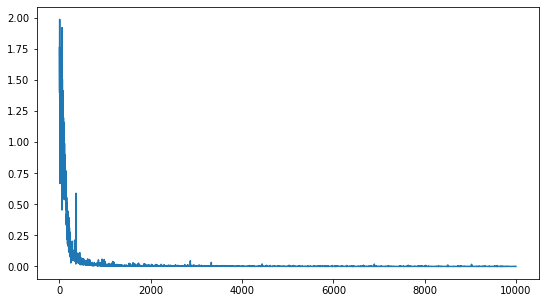

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(loss_history)

plt.show()

In [ ]:
#evaluation

correct_preds = 0
total_preds = 0
for sentence, tags in tqdm(ds):
    tag_scores = model(sentence)
    preds = tag_scores.argmax(-1)
    correct_preds += (preds == tags).sum().item()
    total_preds += len(tags)

print()
print("model accuracy: {:.3f}".format(100*correct_preds/total_preds))

100%|██████████| 10000/10000 [02:02<00:00, 81.73it/s]


model accuracy: 100.000


The evaluation shows 100% accuracy on our training data. <br>
This is not surprising, since it was very easy for our model to pick up the rules from the esperanto language. As we explained before, this language has a very regular grammar. For example all nouns have the ending -o, for adjectives it's -a. This is why it wasn't challenging to achieve good performance(or even perfect we might say).

We can try and see the predictions on the first sentence of our dataset

In [ ]:
example1 = ds[0]

tag_scores = model(example1[0])
preds = tag_scores.argmax(-1)

tags = [ix2tags[p.item()] for p in preds]

with open(ds_link, 'r') as f:
  i = 0
  l = f.readline()
  while l != '\n':
    l = l.replace('\n', '')
    print(f"{l} - pred: {tags[i]}")
    l = f.readline()
    i += 1

Ĉu O - pred: O
. O - pred: O
. O - pred: O
. O - pred: O
preĝi PRON - pred: PRON
mediti PRON - pred: PRON
ricevi PRON - pred: PRON
instigojn O - pred: O
kanti PRON - pred: PRON
muziki PRON - pred: PRON
informiĝi PRON - pred: PRON
legi PRON - pred: PRON
studi PRON - pred: PRON
prepari PRON - pred: PRON
Diservon O - pred: O


Or you can input your own sentence and see what that gives you:

(the word sentences have to be separated by whitespace, and we also assume that the sentence doesn't end in whitespace. Plus make sure to give a valid sentence)


In [ ]:
sentence = input("Enter your sentence: ")

tokens = [2 if c not in vocab else vocab[c] for c in " ".join(sentence)]
tokens.append(1)
tokens = th.tensor(tokens)

tag_scores = model(tokens)
preds = tag_scores.argmax(-1)

tags = [ix2tags[p.item()] for p in preds]

for i, word in enumerate(sentence.split(" ")):
  print(f"{word} - pred: {tags[i]}")